In [ ]:
# colab stuff
import os

if not os.path.exists('./util') :
  !wget https://www.dropbox.com/s/911loiirptr541k/archive.zip?dl=1 -O 'archive.zip'
  !unzip ./archive.zip
  !rm -r __MACOSX
  !rm 'archive.zip'

In [243]:
# ============================================================
# Notebook setup
# ============================================================

!pip install tensorflow
!pip install ipympl

%load_ext autoreload
%autoreload 2
%matplotlib widget
%matplotlib inline

from sklearn.neighbors import KernelDensity
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score
from util import nab
from util import nab2
#from util import nn
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd

# Load data
if os.path.exists('/app/data/nab') : # colab stuff
  data_folder = '/app/data/nab'
else :                               # colab stuff
  data_folder = './data/nab'         # colab stuff
file_name = 'temp_data/data.csv'

You should consider upgrading via the '/usr/local/bin/python -m pip install --upgrade pip' command.


You should consider upgrading via the '/usr/local/bin/python -m pip install --upgrade pip' command.
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


NameError: name 'os' is not defined

In [171]:
data_folder = '/app/data/nab'     # colab stuff
file_name = 'temp_data/data.csv'

## Load the data

In [205]:
data, labels, windows = nab.load_series(file_name, data_folder)

In [206]:
data.head()

,value
timestamp,
2019-07-04 00:00:00,64.2
2019-07-04 01:00:00,49.4
2019-07-04 02:00:00,48.8
2019-07-04 03:00:00,46.4
2019-07-04 04:00:00,47.9


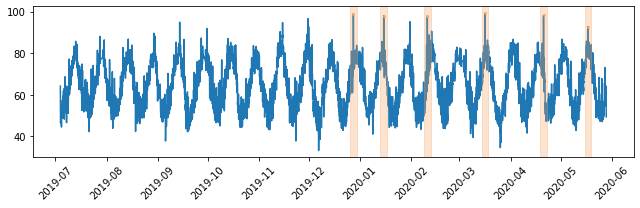

In [207]:
nab.plot_series(data, labels, windows)

# Missing values

Let's check if there are any missing values

In [208]:
delta = data.index[1:] - data.index[:-1]
vc = pd.Series(delta).value_counts()
vc.iloc[:10]

0 days 01:00:00    7770
0 days 02:00:00       2
1 days 08:00:00       2
0 days 03:00:00       1
1 days 01:00:00       1
1 days 06:00:00       1
0 days 15:00:00       1
Name: timestamp, dtype: int64

It seems that the frequency of the time series is 1 hour with some missing values

In [209]:
dindex = pd.date_range(start=data.index[0], end=data.index[-1], freq='1h')
mv = dindex.difference(data.index)
print(mv)

DatetimeIndex(['2019-07-28 02:00:00', '2019-07-28 05:00:00',
               '2019-07-28 06:00:00', '2019-07-28 07:00:00',
               '2019-07-28 08:00:00', '2019-07-28 09:00:00',
               '2019-07-28 10:00:00', '2019-07-28 11:00:00',
               '2019-07-28 12:00:00', '2019-07-28 13:00:00',
               ...
               '2020-03-24 09:00:00', '2020-03-24 10:00:00',
               '2020-03-24 11:00:00', '2020-03-24 12:00:00',
               '2020-03-24 13:00:00', '2020-03-24 14:00:00',
               '2020-03-24 15:00:00', '2020-03-24 16:00:00',
               '2020-03-24 17:00:00', '2020-03-24 18:00:00'],
              dtype='datetime64[ns]', length=133, freq=None)


There are 133 missing values.
We will use a basic approach to fill them, namely, **forward filling**.

Let's plot the time series highlighting the missing values

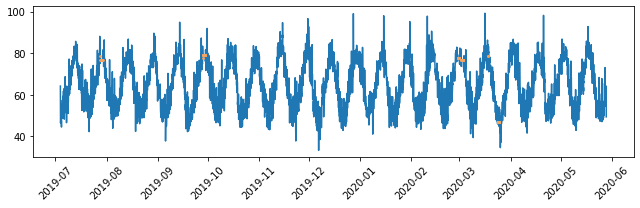

In [210]:
nab.plot_series(data.resample('1h').fillna(method='ffill'), labels=mv)

In [211]:
ddata = nab.densify(data, freq='1h')
ddata.head()

,value
2019-07-04 00:00:00,64.2
2019-07-04 01:00:00,49.4
2019-07-04 02:00:00,48.8
2019-07-04 03:00:00,46.4
2019-07-04 04:00:00,47.9


## Filling missing values

In [212]:
# save the original df
data_old = data.copy()

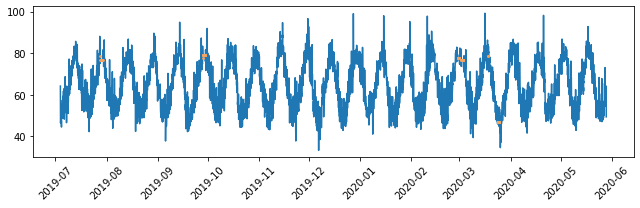

In [213]:
tmp = ddata.fillna(method='ffill')
nab.plot_series(tmp, labels=mv)
data = tmp

# Anomaly Detection and Kernel Density Estimation

Let's see the distribution of our data

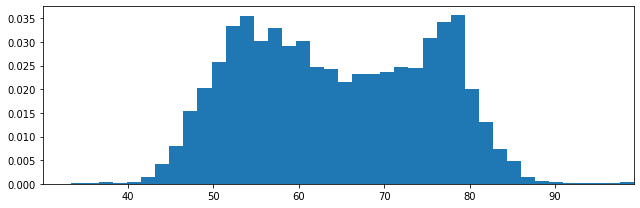

In [214]:
vmax = data['value'].max()
nab.plot_histogram(data['value'], vmax=vmax, bins=40)

This is (roughly) the distribution around the first anomaly:

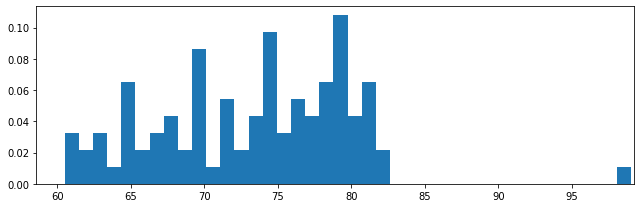

In [215]:
w0_start = windows['begin'][0]
w0_end = windows['end'][0]
data_anomaly0 = data[(data.index >= w0_start) & (data.index < w0_end)]
nab.plot_histogram(data_anomaly0['value'], vmax=vmax, bins=40)

As it can be seen, there is a huge gap that indicates that a value is way higher than the others.

## Training and Testing

Here we chose this date "'2019-12-21 00:00:00'" as a separation between train an test set.
Is important to not have anomalies in the training set because we need to learn the "normal behaviour" of the series, we must not learn on data with anomalies.

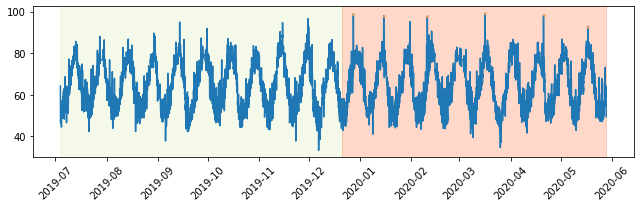

In [216]:
train_end = pd.to_datetime('2019-12-21 00:00:00')
nab.plot_series(data, labels, test_start=train_end)

## Standardize

Here we standardize the entire dataset using the mean and standard deviation of the temperature value of _the training set alone_.
Is really important to have only the training data. If we would have also the
test set, we would implicitly be taking some test set information to compute the standardization factor.

In [217]:
tmp = data[data.index < train_end] # take only the training data

# standardize
data['value'] = (data['value'] - tmp['value'].mean()) / tmp['value'].std()

data_tr = data[data.index < train_end] # as before, we are taking only the training set (which is now standardized)

In [218]:
data[data.index < train_end]

,value
2019-07-04 00:00:00,-0.025313
2019-07-04 01:00:00,-1.394712
2019-07-04 02:00:00,-1.450228
2019-07-04 03:00:00,-1.672293
2019-07-04 04:00:00,-1.533502
...,...
2019-12-20 19:00:00,-1.524249
2019-12-20 20:00:00,-1.237416
2019-12-20 21:00:00,-0.589728
2019-12-20 22:00:00,-1.154142


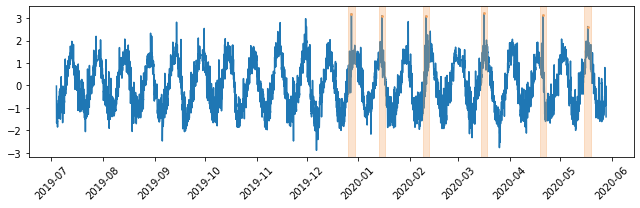

In [219]:
nab.plot_series(data, labels, windows)

As it can be seen, the values on the column are normalized.

In [220]:
q1 = data_tr['value'].quantile(0.25)
q3 = data_tr['value'].quantile(0.75)
sigma = data_tr['value'].std()
m =  len(data_tr)
h = 0.9 * min(sigma, (q3-q1) / 1.34) * m**(-0.2)
print(f'The estimated bandwidth is {h}')

The estimated bandwidth is 0.170651644133972


Here we fit the KDE esitmator using a `gaussian` kernel.

In [221]:
kde = KernelDensity(kernel='gaussian', bandwidth=h)
kde.fit(data_tr);

Let's have a look at the estimate distribution:

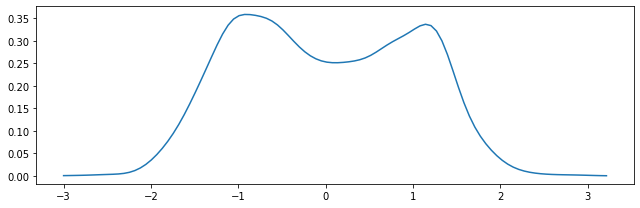

In [222]:
vmax = data['value'].max()
xr = np.linspace(-3, vmax, 100)
nab.plot_density_estimator_1D(kde, xr)

If you take a closer look, this estimated distribution is very similar to the distribution of our data we computed before, let's look again at it and compare the two.

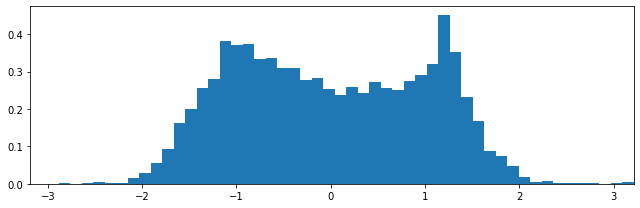

In [223]:
vmax = data['value'].max()
nab.plot_histogram(data['value'], vmax=vmax, bins=50)

## Alarm signal

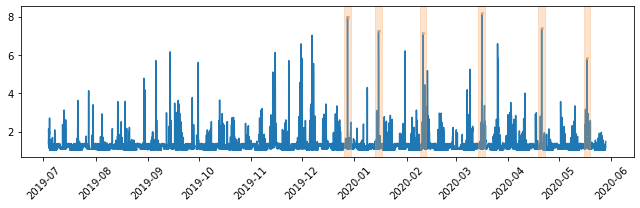

In [224]:
# Obtain the log probability density for all the data
ldens = kde.score_samples(data)
# Convert to a pandas series (add the time index)
signal = pd.Series(index=data.index, data=-ldens) # note the "-" sign to negate the logarithm
# Plot the signal over time
nab.plot_series(signal, labels=labels, windows=windows)

## Chosing the threshold

As it can be seen, there are peaks in proximity of the anomalies. What we need to do now is to find a threshold that tells us which of the peaks we found are actually anomalies and which are not.

### Cost model

The cost defined below are **company dependent**, which means that their values highly depends on the "company business". We asked the company to give us the values of the importance of these costs within a range 0-10.
The values they gave us are the following:
* $c_{alarm}: 0.5$
* $c_{missed}: 10$
* $c_{late}: 7$

**Company result: 41.5**

In [225]:
c_alrm = 0.5 # Cost of investigating a false alarm
c_missed = 10 # Cost of missing an anomaly
c_late = 7 # Cost for late detection

### Effect of the Threshold

**We can now look over all data at the effect of changing the threshold:**

* This is the _response surface_ or _cost function landscape_

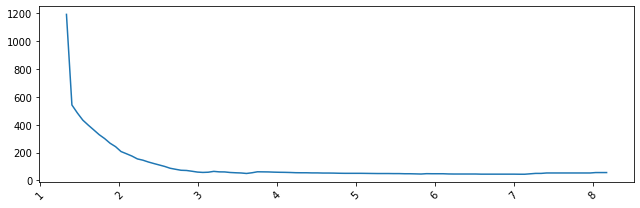

In [226]:
cmodel = nab.ADSimpleCostModel(c_alrm, c_missed, c_late)
thr_range = np.linspace(signal.mean(), signal.max(), 100)
cost_range = [cmodel.cost(signal, labels, windows, thr) for thr in thr_range]
cost_range = pd.Series(index=thr_range, data=cost_range)
nab.plot_series(cost_range)

### Definition of validation set

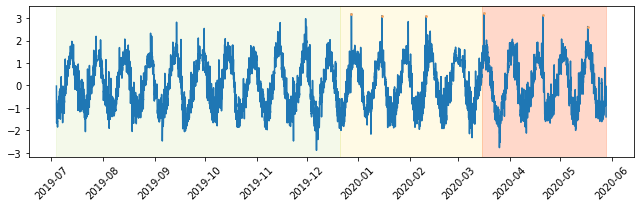

In [227]:
val_end = pd.to_datetime('2020-03-15 00:00:00')
nab.plot_series(data, labels, val_start=train_end, test_start=val_end)

## Optimize the Threshold

In [228]:
signal_opt = signal[signal.index < val_end] # take train + val set
labels_opt = labels[labels < val_end] # extract the position of anomaly
windows_opt = windows[windows['end'] < val_end] # extract thr position of the windows
thr_range = np.linspace(signal.quantile(.75), signal.max(), 100) # range of the thresholds I want to explore

The below function `opt_thr` compute all the possible costs given the thresholds we want to test and return the best threshold. <br>
The reported cost is on the training set:

In [229]:
best_thr, best_cost = nab.opt_thr(signal_opt, labels_opt,
                                  windows_opt,  cmodel, thr_range)
print(f'Best threshold: {best_thr}, corresponding cost: {best_cost}')

Best threshold: 7.077263278309578, corresponding cost: 21.0


The cost for all the data we have:

In [230]:
ctst = cmodel.cost(signal, labels, windows, best_thr)
print(f'Cost on the whole dataset {ctst}')

Cost on the whole dataset 45.0


## Add dayhour

In [231]:
dayhour = (data.index.hour + data.index.minute / 60)
dayhour = dayhour / 24 # normalize

In [232]:
data2 = data.copy()
data2['dayhour'] = dayhour

In [233]:
from sklearn.model_selection import GridSearchCV
# Build the grid search optimizer
params = {'bandwidth': np.linspace(0.001, 0.01, 10)}
opt = GridSearchCV(KernelDensity(kernel='gaussian'), params, cv=5)

In [234]:
data2_tr = data2[data2.index < train_end]
opt.fit(data2_tr);

In [235]:
opt.best_params_

{'bandwidth': 0.01}

In [236]:
h = opt.best_params_['bandwidth']
kde2 = KernelDensity(kernel='gaussian', bandwidth=h)
kde2.fit(data2_tr)

KernelDensity(bandwidth=0.01)

In [244]:
ldens2 = kde2.score_samples(data2)
signal2 = pd.Series(index=data2.index, data=-ldens2)
nab.plot_series(signal2, labels=labels, windows=windows)

UsageError: Line magic function `%` not found.


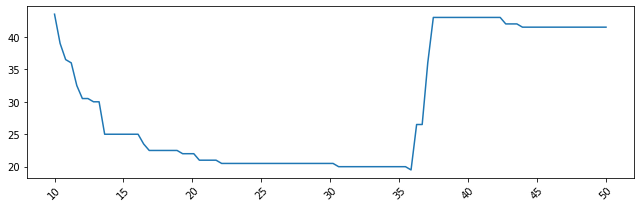

In [245]:
thr2_range = np.linspace(10, 50, 100)
cost2_range = [cmodel.cost(signal2, labels, windows, thr)
for thr in thr2_range]
cost2_range = pd.Series(index=thr2_range, data=cost2_range)
nab.plot_series(cost2_range)


In [239]:
signal2_opt = signal2[signal2.index < val_end]
best_thr2, best_cost2 = nab.opt_thr(signal2_opt, labels_opt,
windows_opt, cmodel, thr2_range)
print(f'Best threshold: {best_thr2}, corresponding cost: {best_cost2}')


Best threshold: 35.858585858585855, corresponding cost: 9.0


In [240]:
c2tst = cmodel.cost(signal2, labels, windows, best_thr2)
print(f'Cost on the whole dataset {c2tst}')

Cost on the whole dataset 19.5


# Anomaly Detection via Autoregression

### Preparing The  Dataset

Before using Linear Regression, we need to build the target vector.

In this case we want to predict the point which is exactly after the window.

In [107]:
# Apply a sliding window
wlen = 24
wdata = nab.sliding_window_1D(data, wlen=wlen)

AttributeError: module 'util.nab' has no attribute 'sliding_window_2D'

In [ ]:
wdata_out = data.iloc[wlen:]['value'] # wlen is the index after the first window
wdata_out.head()

2019-07-05 00:00:00   -0.950583
2019-07-05 01:00:00   -1.098626
2019-07-05 02:00:00   -0.830298
2019-07-05 03:00:00   -0.987593
2019-07-05 04:00:00   -0.941330
Freq: H, Name: value, dtype: float64

* The last known output will be at the end of the series
* So we need to remove the last row from our sliding window dataset because it will go overflow if we use the last window

In [ ]:
wdata_in = wdata.iloc[:-1]

### Fitting the Linear Model

Next, we need to separate the training set:

In [ ]:
wdata_in_tr = wdata_in[wdata_in.index < train_end]
wdata_out_tr = wdata_out[wdata_out.index <= train_end] # Notice the "<=" sign because the output is one data point
                                                       # after the input

Then, we can train our predictor:

In [ ]:
from sklearn.linear_model import LinearRegression
reg = LinearRegression()
reg.fit(wdata_in_tr, wdata_out_tr);

We can now obtain the predictions:

In [ ]:
%time pred_out = reg.predict(wdata_in)
pred_out = pd.Series(index=wdata_out.index, data=pred_out)

CPU times: user 2.32 ms, sys: 888 µs, total: 3.21 ms
Wall time: 1.67 ms


* The process is now very fast!

**Let us have a look at the prediction quality:**

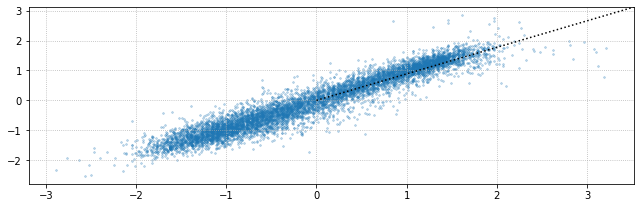

In [ ]:
nab.plot_prediction_scatter(wdata_out, pred_out, )

And here is the R2 score:

In [ ]:
r2_score(wdata_out, pred_out)

0.9218728102244902

### Alarm Signal

We now just need to compute the errors to obtain our signal.

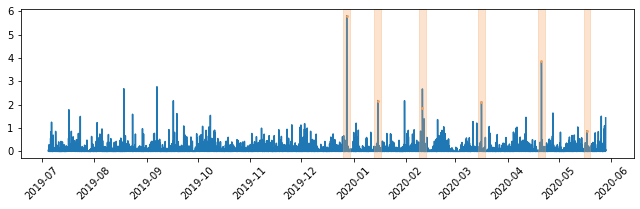

In [ ]:
err = wdata_out - pred_out
signal = np.square(err)
nab.plot_series(signal, labels, windows)

### Threshold Optimization

We can proceed as usual, by optimizing the threshold and checking the results

In [ ]:
thr_range = np.linspace(signal.quantile(.75), signal.max(), 100)
signal_opt = signal[signal.index < val_end]
labels_opt = labels[labels < val_end]
windows_opt = windows[windows['end'] < val_end]
best_thr, best_cost = nab.opt_thr(signal_opt, labels_opt,
                                  windows_opt,  cmodel, thr_range)
print(f'Best threshold: {best_thr}, corresponding cost: {best_cost}')

Best threshold: 1.87183032000898, corresponding cost: 16.0


In [ ]:
ctst = cmodel.cost(signal, labels, windows, best_thr)
print(f'Cost on the whole dataset {ctst}')

Cost on the whole dataset 40.0


The cost is very good! **The advantage** we have with Linear Regression is the speed of prediction and also in this case we managed to reduce the error on the whole dataset.

### Sliding window optimization

In [ ]:
best_cost = np.inf
best_wl = 0
for wl in [1] + list(range(6, 24*3, 6)):    
    wlen = wl
    wdata = nab.sliding_window_1D(data, wlen=wlen)

    wdata_out = data.iloc[wlen:]['value']

    wdata_in = wdata.iloc[:-1]

    wdata_in_tr = wdata_in[wdata_in.index < train_end]
    wdata_out_tr = wdata_out[wdata_out.index <= train_end]

    reg = LinearRegression()
    reg.fit(wdata_in_tr, wdata_out_tr);

    pred_out = pd.Series(index=wdata_out.index, data=pred_out)

    thr_range = np.linspace(signal.mean(), signal.max(), 100)
    signal_opt = signal[signal.index < val_end]
    labels_opt = labels[labels < val_end]
    windows_opt = windows[windows['end'] < val_end]
    best_thr, _ = nab.opt_thr(signal_opt, labels_opt,
                                      windows_opt,  cmodel, thr_range)
    ctst = cmodel.cost(signal, labels, windows, best_thr)
    if ctst < best_cost:
        best_cost = ctst
        best_wl = wl
    
print(f'Cost on the whole dataset {best_cost}')

Cost on the whole dataset 40.0


# Time Indexed Linear Regression

In this case the idea is to have a linear regression and to have a sort of time indexed model with a **longer period**.

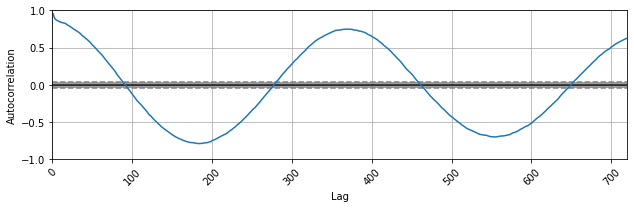

In [ ]:
%matplotlib inline
nab.plot_autocorrelation(data_tr, max_lag=720)

The autocorrelation is quite strong in the upper 300s, let's try to see if FFT can tell us more about plausible periods.

A better method to find seasonality in our data consist in using frequence analysis

First we compute the FFT amplitudes

In [ ]:
from numpy.fft import fft
y = fft(data[data.index < train_end]['value'])

We can get the corresponding frequencies with:

In [ ]:
from numpy.fft import fftfreq
f = fftfreq(len(data_tr))
print(f)

[ 0.          0.0002451   0.0004902  ... -0.00073529 -0.0004902
 -0.0002451 ]


The frequencies are in cycles/`d` (cicles per time, 1 hour, in our case)

We care only about the positive frequencies

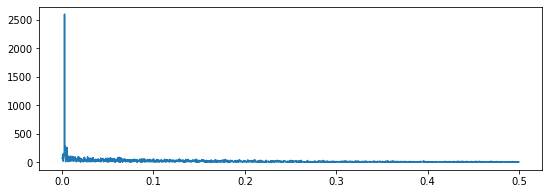

In [ ]:
n = len(data_tr)
plt.figure(figsize=nab.figsize)
plt.plot(f[1:n//2], np.abs(y[1:n//2]))
plt.xticks()
plt.show()

First, we focus on the positive frequencies

In [ ]:
yp = y[1:n//2]
fp = f[1:n//2]

Then, we select the frequencies with a strong (absolute) amplitude (in our case, above 100):

In [ ]:
fp_peak = fp[np.abs(yp) >= 100]

And we invert them to obtain the periods (in time steps):

In [ ]:
np.unique(np.round(1/fp_peak))

array([  83.,  105.,  107.,  146.,  177.,  185.,  194.,  204.,  227.,
        240.,  272.,  291.,  314.,  340.,  371.,  408.,  453.,  510.,
       1020., 1360.])

Which in days is:

In [ ]:
np.unique(np.round(1/fp_peak)) / 24 # our time series as a frequency of 1 hour,
                                     # so we are checking to how many days these periods
                                     # refer to

array([ 3.45833333,  4.375     ,  4.45833333,  6.08333333,  7.375     ,
        7.70833333,  8.08333333,  8.5       ,  9.45833333, 10.        ,
       11.33333333, 12.125     , 13.08333333, 14.16666667, 15.45833333,
       17.        , 18.875     , 21.25      , 42.5       , 56.66666667])

We mainly have two groups:
- 6, 7(2x), 8(2x), 9 and 10 which might be representing a **weekly** period
- 12 up to 18 days which might indicate a something like a **two-weeks** period or similar

We start by getting all unique _hours-of-period_ values, in this case we are trying to exploit a **weekly** period

In [ ]:
period = 7 # in days

In [ ]:
# since we have one timestep per hour we can just use np.arange
week_hours = np.arange(0, 24*period, dtype=np.int32)
print(week_hours[-5:])

[163. 164. 165. 166. 167.]


### Learning the Ensemble

Then we need to train a bunch of regressors. The way we slice the time series has a step of 24*period datapoints.

**For each hour of the week, we need to define _both input and output data_**

In [ ]:
lr = {}
for hidx, how in enumerate(week_hours):
    tmp_in = wdata_in_tr.iloc[hidx::24*period]
    tmp_out = wdata_out_tr.iloc[hidx::24*period]
    lr[how] = LinearRegression()
    lr[how].fit(tmp_in, tmp_out)

### Generating the Signal

We compute our predictions and we obtain the corresponding errors.

**Now we can generate the alarm signal**

First we run all the estimators:

In [ ]:
err_list = []
for hidx, how in enumerate(week_hours):
    tmp_in = wdata_in.iloc[hidx::24*period]
    tmp_out = wdata_out.iloc[hidx::24*period]
    tmp_pred = lr[how].predict(tmp_in)
    tmp_err = np.abs(tmp_out - tmp_pred)
    tmp_err = pd.Series(index=tmp_out.index, data=tmp_err)
    err_list.append(tmp_err)

Then, once we have all the different errors for the different hours of the week, we pur everything together and we sort by our temporal index and by doing this we obtain a complete error signal.

In [ ]:
signal = pd.concat(err_list, axis=0).sort_index()

### Threshold Optimization

**Finally we optimize the threshold:**

In [ ]:
thr_range = np.linspace(signal.mean(), signal.max(), 100)
signal_opt = signal[signal.index < val_end]
labels_opt = labels[labels < val_end]
windows_opt = windows[windows['end'] < val_end]

best_thr, best_cost = nab.opt_thr(signal_opt, labels_opt,
                                  windows_opt,  cmodel, thr_range)
print(f'Best threshold: {best_thr}, corresponding cost: {best_cost}')

Best threshold: 1.5359836691724893, corresponding cost: 15.5


Cost on the whole dataset:

In [ ]:
ctst = cmodel.cost(signal, labels, windows, best_thr)
print(f'Cost on the whole dataset {ctst}')

Cost on the whole dataset 42.0


### Sliding window and period optimization

In [ ]:
best_cost = np.inf
best_wl = 2
best_p = 2
dt = data

for wl in range(6, 24*3, 6):
    for p in range(7, 7*6, 7):
        wlen = wl
        wdata = nab.sliding_window_1D(dt, wlen=wlen)

        # Prepare input and output data
        wdata_out = dt.iloc[wlen:]['value']
        wdata_in = wdata.iloc[:-1]

        # Separate the training data
        wdata_in_tr = wdata_in[wdata_in.index < train_end]
        wdata_out_tr = wdata_out[wdata_out.index <= train_end] # Notice the "<=" sign

        period = p # in days

        week_hours = np.arange(0, wlen*period, dtype=np.float64)

        lr = {}
        for hidx, how in enumerate(week_hours):
            tmp_in = wdata_in_tr.iloc[hidx::wlen*period]
            tmp_out = wdata_out_tr.iloc[hidx::wlen*period]
            lr[how] = LinearRegression()
            lr[how].fit(tmp_in, tmp_out)

        err_list = []
        for hidx, how in enumerate(week_hours):
            tmp_in = wdata_in.iloc[hidx::wlen*period]
            tmp_out = wdata_out.iloc[hidx::wlen*period]
            tmp_pred = lr[how].predict(tmp_in)
            tmp_err = np.abs(tmp_pred - tmp_out)
            tmp_err = pd.Series(index=tmp_out.index, data=tmp_err)
            err_list.append(tmp_err)

        signal = pd.concat(err_list, axis=0).sort_index()

        thr_range = np.linspace(signal.mean(), signal.max(), 100)
        signal_opt = signal[signal.index < val_end]
        labels_opt = labels[labels < val_end]
        windows_opt = windows[windows['end'] < val_end]

        best_thr, _ = nab.opt_thr(signal_opt, labels_opt,
                                          windows_opt,  cmodel, thr_range)

        ctst = cmodel.cost(signal, labels, windows, best_thr)
        if ctst < best_cost:
            best_cost = ctst
            best_wl = wl
            best_p = p
    
print(f'Cost on the whole dataset {best_cost}')

Cost on the whole dataset 29.0


# DBSCAN

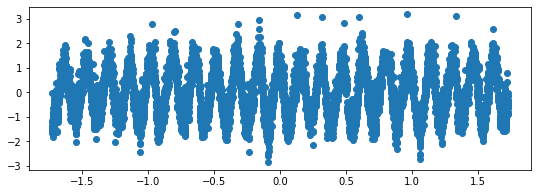

In [ ]:
from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.datasets import make_blobs

a = []
x = []
y=[]
for i in range(0, len(data)-1):
    a.append([i, data["value"][i]])    

X = a

X = StandardScaler().fit_transform(X)
for i in range(0,len(X)):
    x.append(X[i][0])
    y.append(X[i][1])

plt.figure(figsize=nab.figsize)
plt.scatter(x,y)
plt.show()

Estimated number of clusters: 1


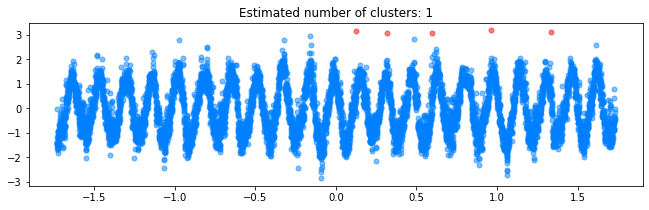

In [ ]:
db = DBSCAN(eps=0.6, min_samples=20).fit(X)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(db.labels_)) - (1 if -1 in db.labels_ else 0)

print('Estimated number of clusters: %d' % n_clusters_)

unique_labels = set(db.labels_)
plt.figure(num=None, figsize=(11,3), facecolor='w', edgecolor='k')
for k in unique_labels:
    col=[0,0.5,1,1]
    if k == -1:
        col = [1, 0, 0, 1]
    class_member_mask = (db.labels_ == k)

    xy = X[class_member_mask & core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', color=tuple(col),markersize=5, alpha=0.5)

    xy = X[class_member_mask & ~core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', color=tuple(col), markersize=5, alpha=0.5)

plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.show()

Let's compare it with our original series:

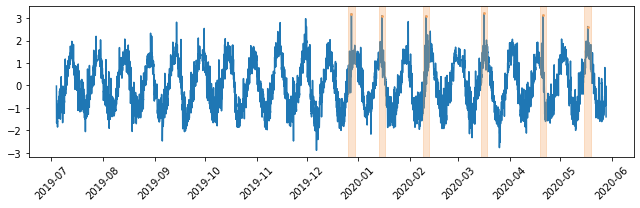

In [ ]:
nab.plot_series(data, labels, windows)

In [ ]:
signal_db = pd.Series(index=(data[:-1][db.labels_ == -1]).index, data=X[class_member_mask & (db.labels_ == k)][:, 1])

In [ ]:
thr_range = np.linspace(signal_db.quantile(.75), signal.max(), 100)
signal_opt = signal_db[signal_db.index < val_end]
labels_opt = labels[labels < val_end]
windows_opt = windows[windows['end'] < val_end]
best_thr, best_cost = nab.opt_thr(signal_opt, labels_opt,
                                  windows_opt,  cmodel, thr_range)
print(f'Best threshold: {best_thr}, corresponding cost: {best_cost}')

Best threshold: 3.174050750838075, corresponding cost: 27.0


In [ ]:
ctst = cmodel.cost(signal_db, labels, windows, best_thr)
print(f'Cost on the whole dataset {ctst}')

Cost on the whole dataset 54.0


# Autoencoder

In [ ]:
# specific libraries for NN
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, regularizers
from tensorflow.keras.layers import Input, Dense, Activation, Dropout, Bidirectional, LSTM, Reshape, GRU, Concatenate, Lambda
from tensorflow.keras.models import Sequential, Model
import time #helper libraries
from tensorflow.keras.models import model_from_json

This is the model architecture, a basic autoencoder model:

In [ ]:
def build_ae(units) :
  ae_x = Input(shape=(1,), dtype='float32')
  ae_z = Dense(units, activation='tanh')(ae_x)
  ae_y = Dense(1, activation='linear')(ae_z)
  ae = Model(ae_x, ae_y)
  ae.compile(optimizer='adam', loss='mse')
  return ae

ae = build_ae(14)

In [ ]:
data_tr = data[data.index < train_end]
data_val = data[(data.index >= train_end) & (data.index < val_end)]

In [ ]:
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, mode='min', restore_best_weights=True)

history = ae.fit(data_tr.values, data_tr.values,
                 validation_data = (data_val.values, data_val.values),
                 callbacks=[es],
                 batch_size=48, epochs=100, verbose=0)

In [ ]:
preds = pd.DataFrame(index=data.index, columns=data.columns, data=ae(data.values).numpy())
preds.head()

,value
2019-07-04 00:00:00,-0.025467
2019-07-04 01:00:00,-1.403565
2019-07-04 02:00:00,-1.458227
2019-07-04 03:00:00,-1.671790
2019-07-04 04:00:00,-1.539318


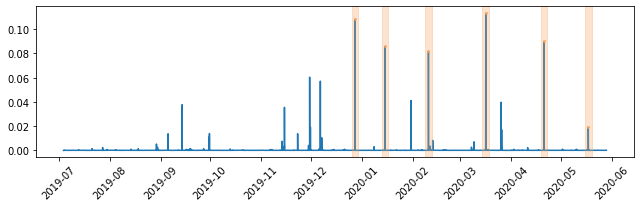

In [ ]:
se = np.square(data['value'] - preds['value'])
signal_ae = pd.Series(index=data.index, data=se)
nab.plot_series(signal_ae, labels, windows, figsize=nab.figsize)

In [ ]:
thr_range = np.linspace(signal_ae.quantile(0.5), signal_ae.max(), 100)
signal_opt = signal_ae[signal_ae.index < val_end]
labels_opt = labels[labels < val_end]
windows_opt = windows[windows['end'] < val_end]
best_thr, best_cost = nab.opt_thr(signal_opt, labels_opt,
                                  windows_opt,  cmodel, thr_range)
print(f'Best threshold: {best_thr}, corresponding cost: {best_cost}')

Best threshold: 0.06063388937733115, corresponding cost: 21.0


In [ ]:
ctst = cmodel.cost(signal_ae, labels, windows, best_thr)
print(f'Cost on the whole dataset {ctst}')

Cost on the whole dataset 45.0


# RNN

We prepare the data by applying a sliding window of **24 time steps** (1 day)

In [ ]:
TIME_STEPS = 24
features = len(data.columns)

wdata = nab.sliding_window_1D(data, wlen=TIME_STEPS) 

wdata_out = data.iloc[TIME_STEPS:]['value']
wdata_in = wdata.iloc[:-1]

wdata_in_tr = wdata_in[wdata_in.index < train_end]
wdata_out_tr = wdata_out[wdata_out.index <= train_end]

mask = (wdata_in.index >= train_end) & (wdata_in.index < val_end)
wdata_in_val = wdata_in[mask]
mask = (wdata_out.index > train_end) & (wdata_out.index <= val_end)
wdata_out_val = wdata_out[mask]

wdata_in_test = wdata_in[wdata_in.index >= val_end]
wdata_out_test = wdata_out[wdata_out.index > val_end]

datasv, labels, windows = nab.load_series(file_name, data_folder)
datasv['value'] = (datasv['value'] - datasv['value'].mean()) / datasv['value'].std()
wdata_sv = nab.sliding_window_1D(datasv, wlen=TIME_STEPS) 
wdata_out_sv = datasv.iloc[TIME_STEPS:]['value']
wdata_in_sv = wdata_sv.iloc[:-1]

x_train = wdata_in_tr.values.reshape(-1, TIME_STEPS, features)
x_val = wdata_in_val.values.reshape(-1, TIME_STEPS, features)
x_test = wdata_in_test.values.reshape(-1, TIME_STEPS, features)

print(f"Train shape: {x_train.shape, wdata_out_tr.shape}")
print(f"Val shape: {x_val.shape, wdata_out_val.shape}")
print(f"Test shape: {x_test.shape, wdata_out_test.shape}")

Train shape: ((4057, 24, 1), (4057,))
Val shape: ((2040, 24, 1), (2040,))
Test shape: ((1791, 24, 1), (1791,))


In [ ]:
import gc
gc.collect()

66351

# RNNs for anomaly detection

Here we are trying another approach based on Neural Networks: **Recurrent Neural Networks (RNN)**, in particular we are using **LSTM**s.  
The idea is to **feed a _sequence_** of $n$ values as input to the RNN and make it learn to output the $n+1^{th}$ value.

In [ ]:
# Build the model
def build_model(units, input_shape, dropout=0.0) :
  model = Sequential()
  model.add(Input((input_shape)))
  model.add(LSTM(units, return_sequences=False))
  model.add(Dropout(dropout))
  model.add(Dense(units//2, activation='tanh'))
  model.add(Dense(features, activation='linear'))
  model.compile(optimizer=optimizers.Adam(1e-2), loss='mse')
  return model

In [ ]:
tf.keras.backend.clear_session()

model = build_model(8, input_shape=x_train.shape[1:], dropout=0.1)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 8)                 320       
_________________________________________________________________
dropout (Dropout)            (None, 8)                 0         
_________________________________________________________________
dense (Dense)                (None, 4)                 36        
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 5         
Total params: 361
Trainable params: 361
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Train the model
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, mode='min', restore_best_weights=True)

history = model.fit(x_train, wdata_out_tr, 
                    epochs=100,
                    batch_size=128, 
                    validation_data=(x_val, wdata_out_val),
                    callbacks=[es],
                    shuffle=False)

Epoch 1/100
32/32 [==============================] - 2s 18ms/step - loss: 0.8301 - val_loss: 0.1688
Epoch 2/100
32/32 [==============================] - 0s 6ms/step - loss: 0.1610 - val_loss: 0.1320
Epoch 3/100
32/32 [==============================] - 0s 6ms/step - loss: 0.1392 - val_loss: 0.1204
Epoch 4/100
32/32 [==============================] - 0s 7ms/step - loss: 0.1302 - val_loss: 0.1155
Epoch 5/100
32/32 [==============================] - 0s 6ms/step - loss: 0.1257 - val_loss: 0.1095
Epoch 6/100
32/32 [==============================] - 0s 6ms/step - loss: 0.1191 - val_loss: 0.1052
Epoch 7/100
32/32 [==============================] - 0s 6ms/step - loss: 0.1138 - val_loss: 0.1004
Epoch 8/100
32/32 [==============================] - 0s 6ms/step - loss: 0.1128 - val_loss: 0.0978
Epoch 9/100
32/32 [==============================] - 0s 6ms/step - loss: 0.1090 - val_loss: 0.0936
Epoch 10/100
32/32 [==============================] - 0s 5ms/step - loss: 0.1065 - val_loss: 0.0894
Epoch 11

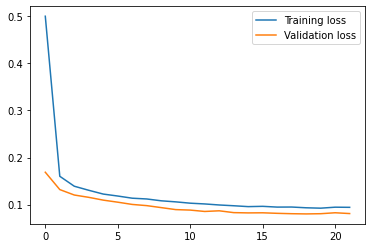

In [ ]:
%matplotlib inline

plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()
plt.show()

In [ ]:
x = wdata_in.values.reshape(-1, TIME_STEPS, features)
pred_out = model.predict(x)

Let's compare the reconstructed signal with the original one:

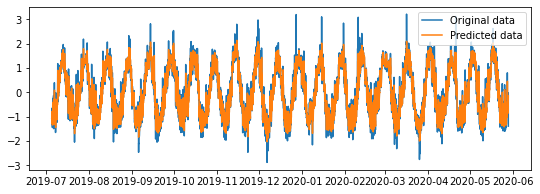

In [ ]:
pred_data = pd.Series(index=wdata_out.index, data=pred_out.reshape(-1))
fig = plt.figure(figsize=nab.figsize)
plt.plot(wdata_out, label='Original data')
plt.plot(pred_data, label='Predicted data')
plt.legend()
plt.show()

And that's the error signal:

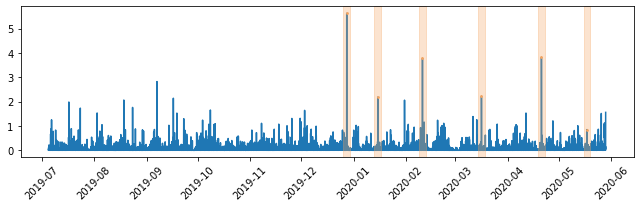

In [ ]:
err = wdata_out.values - pred_out.reshape(-1)
signal = np.square(err)
signal = pd.Series(index=wdata_out.index, data=signal)

nab.plot_series(signal, labels, windows)

Threshold optimization:

In [ ]:
thr_range = np.linspace(signal.quantile(0.95), signal.max(), 100)
signal_opt = signal[signal.index < val_end]
labels_opt = labels[labels < val_end]
windows_opt = windows[windows['end'] < val_end]
best_thr, best_cost = nab.opt_thr(signal_opt, labels_opt,
                                  windows_opt,  cmodel, thr_range)
print(f'Best threshold: {best_thr}, corresponding cost: {best_cost}')

Best threshold: 2.15361677597268, corresponding cost: 14.5


In [ ]:
ctst = cmodel.cost(signal, labels, windows, best_thr)
print(f'Cost on the whole dataset {ctst}')

Cost on the whole dataset 38.5


# Ensamble of RNN

We also tried to build an ensamble of RNNs, one for every _hour-of-period_ (_hop_).

First we prepare the input data: a mini-dataset for every _hop_

In [ ]:
period = 7

x_train_ens = {}
y_train_ens = {}
x_val_ens = {}
y_val_ens = {}
x_test_ens = {}
y_test_ens = {}

x = {}
y = {}

for hop in range(TIME_STEPS*period) :
  x_train_ens[hop] = (wdata_in_tr.iloc[hop::TIME_STEPS*period].values.reshape(-1, TIME_STEPS, features))
  y_train_ens[hop] = (wdata_out_tr.iloc[hop::TIME_STEPS*period])
  x_val_ens[hop] = (wdata_in_val.iloc[hop::TIME_STEPS*period].values.reshape(-1, TIME_STEPS, features))
  y_val_ens[hop] = (wdata_out_val.iloc[hop::TIME_STEPS*period])
  x_test_ens[hop] = (wdata_in_test.iloc[hop::TIME_STEPS*period].values.reshape(-1, TIME_STEPS, features))
  y_test_ens[hop] = (wdata_out_test.iloc[hop::TIME_STEPS*period])
  x[hop] = wdata_in.iloc[hop::TIME_STEPS*period].values.reshape(-1, TIME_STEPS, features)
  y[hop] = wdata_out.iloc[hop::TIME_STEPS*period]


print(f"Number of hops: {len(x_train_ens)}")
print(f"Train shape: {x_train_ens[0].shape, y_train_ens[0].shape}")
print(f"Val shape: {x_val_ens[0].shape, y_val_ens[0].shape}")
print(f"Test shape: {x_test_ens[0].shape, y_test_ens[0].shape}")

Number of hops: 168
Train shape: ((25, 24, 1), (25,))
Val shape: ((13, 24, 1), (13,))
Test shape: ((11, 24, 1), (11,))


In [ ]:
import gc
gc.collect()
tf.keras.backend.clear_session()

es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, mode='min', restore_best_weights=True)


rnns = {}
preds = {}

for hidx in range(TIME_STEPS*period) :
  rnns[hidx] = build_model(8, (TIME_STEPS, features))
  rnns[hidx].fit(x_train_ens[hidx], y_train_ens[hidx], 
                    epochs=100,
                    batch_size=x_train_ens[hidx].shape[0]//10, 
                    validation_data=(x_val_ens[hidx], y_val_ens[hidx]),
                    callbacks=[es],
                    shuffle=False,
                    verbose=0)
  preds[hidx] = rnns[hidx](x[hidx]).numpy().reshape(-1)
  preds[hidx] = pd.Series(index=y[hidx].index, data=preds[hidx])
  rnns[hidx] = None
  gc.collect()
  if (hidx % (TIME_STEPS * period // 10)) == 0 :
    print(f'RNN for hod {hidx} trained.')

RNN for hod 0 trained.
RNN for hod 16 trained.
RNN for hod 32 trained.
RNN for hod 48 trained.
RNN for hod 64 trained.
RNN for hod 80 trained.
RNN for hod 96 trained.
RNN for hod 112 trained.
RNN for hod 128 trained.
RNN for hod 144 trained.
RNN for hod 160 trained.


This is the output signal:

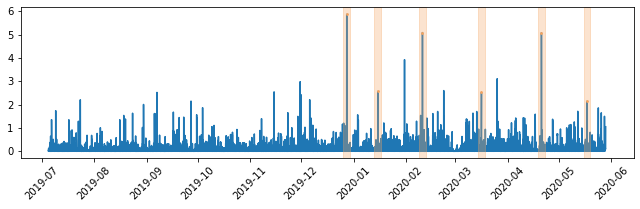

In [ ]:
signal = pd.concat(list(preds.values()), axis=0).sort_index()
signal = np.square(signal.values.reshape(-1) - wdata_out.values.reshape(-1))
signal = pd.Series(index=wdata_out.index , data=signal)
nab.plot_series(signal, labels, windows)

Again, we do the thresold optimization as usual:

In [ ]:
thr_range = np.linspace(signal.mean(), signal.max(), 100)
signal_opt = signal[signal.index < val_end]
labels_opt = labels[labels < val_end]
windows_opt = windows[windows['end'] < val_end]
best_thr, best_cost = nab.opt_thr(signal_opt, labels_opt,
                                  windows_opt,  cmodel, thr_range)
print(f'Best threshold: {best_thr}, corresponding cost: {best_cost}')

Best threshold: 2.267058321714693, corresponding cost: 17.0


In [ ]:
ctst = cmodel.cost(signal, labels, windows, best_thr)
print(f'Cost on the whole dataset {ctst}')

Cost on the whole dataset 41.5


# Future work

* We are already quite happy with the results we could obtain but always looking for improvements. 
* Another approach that could be implemented and might give better result than our RNN approach is a _CNN encoder + RNN decoder with attention_.